In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import os
#os.chdir("/content/drive/My Drive/Deep_Deblur_Data")
#!ls
#!unzip "DeepDeblur.zip"
os.chdir("/content/drive/My Drive/GOPRO_Large_Data")
#!ls "train"
# !mv "train" "GOPRO_Large/"
# !mv "test" "GOPRO_Large/"
#!unzip "GOPRO_Large.zip"

#!ls
#!pwd
#!rm -r blur_sub_images_1
#! rm -r sub_images
#!rm -r sub_images

# res_d="/content/drive/My Drive/Deep_Deblur_Data/DeepDeblur-Pytorch/experiment"
# os.chdir(res_d)
# !unzip "DeepDeblur_pretrained.zip"

Mounted at /content/drive


In [ ]:
os.chdir("/content/drive/My Drive/indoor_CVPR_Data")
#!unzip "blur_images.zip"
!ls
#!tar -xvf "indoorCVPR_09.tar"


blur_images  blur_images.zip  Images  indoorCVPR_09.tar


In [ ]:

#!unzip "/content/drive/My Drive/Deep_Deblur_Data/DeepDeblur.zip"
#!mv "/content/drive/My Drive/Deep_Deblur_Data/DeepDeblur/experiment/Deepdeblur_pretrained.zip" "/content/drive/My Drive/Deep_Deblur_Data/experiment" 
#!mv "/content/drive/My Drive/Deep_Deblur_Data/experiment" "/content/drive/My Drive/Deep_Deblur_Data/DeepDeblur-Pytorch/experiment"
#!unzip "/content/drive/My Drive/GOPRO_Large_Data/GOPRO_Large.zip"
#!mv "/content/drive/My Drive/Deep_Deblur_Data/test" "/content/drive/My Drive/GOPRO_Large_Data/GOPRO_Large"
#!ls

#os.chdir("/content/drive/My Drive/Deep_Deblur_Data/DeepDeblur-PyTorch/experiment")
#!unzip Deepdeblur_pretrained.zip

#!mv "/content/drive/My Drive/GOPRO_Large_Data/GOPRO_Large/test/GOPR0384_11_00/blur_gamma/to_test.png" "/content/drive/My Drive/DeepDeblur_Test"
# os.chdir("/content/drive/My Drive")
# !tar -xvf indoorCVPR.tar/indoorCVPR_09.tar



In [ ]:
import torch
import matplotlib
import matplotlib.pyplot as plt
import time
import h5py
import torch.optim as optim
import torch.nn as nn
import numpy as np
import math
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torchvision.utils import save_image
matplotlib.style.use('ggplot')

import cv2
import os
import glob
from PIL import Image
from google.colab.patches import cv2_imshow
import random
import time
import sys
import math
import shutil

batch_size=30
lr=0.00005
no_epochs=500


In [ ]:
# os.chdir("/content/drive/My Drive/Deep_Deblur_Data/DeepDeblur-PyTorch/src")
# !python main.py --save_dir "GOPRO_L1" --demo True --demo_input_dir "/content/drive/My Drive/DeepDeblur_Test"

In [ ]:
train_dir="/content/drive/My Drive/GOPRO_Large_Data/GOPRO_Large/train"
test_dir="/content/drive/My Drive/GOPRO_Large_Data/GOPRO_Large/test"
deep_deblur_src="/content/drive/My Drive/Deep_Deblur_Data/DeepDeblur-PyTorch/src"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.chdir(train_dir)
!ls

GOPR0372_07_00	GOPR0374_11_03	GOPR0384_11_02	GOPR0477_11_00	GOPR0881_11_00
GOPR0372_07_01	GOPR0378_13_00	GOPR0384_11_03	GOPR0857_11_00	GOPR0884_11_00
GOPR0374_11_00	GOPR0379_11_00	GOPR0384_11_04	GOPR0868_11_01
GOPR0374_11_01	GOPR0380_11_00	GOPR0385_11_00	GOPR0868_11_02
GOPR0374_11_02	GOPR0384_11_01	GOPR0386_11_00	GOPR0871_11_01


In [ ]:
import torch
import torch.nn as nn
import math
import torch.nn.init as init
import os
import torch.nn.functional as F

class ResBLock(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1):   # inchannel is # of input channels.
        super(ResBLock, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(inchannel, outchannel, 5, stride, 2, bias=True),  # 5 is kernel size, padding is 5
            #nn.BatchNorm2d(outchannel)
            nn.ReLU(inplace=True),
            nn.Conv2d(outchannel, outchannel, 5, stride, 2, bias=True)
            #nn.BatchNorm2d(outchannel)
        )

    def forward(self, x):      
        out = self.layers(x)     # both out and residual have 64 channels 
        residual = x   
        #print("resdiual/x.shape- ",residual.shape)
        #print("out_orig.shape- ",out.shape)
        out = torch.add(residual, out)  # out must be a scalar no?
        #print("out_new.shape- ",out.shape)
        return out 

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        stride=1
        self.c1=nn.Conv2d(3, 64, 5, stride, 2, bias=True)
        self.r=self._make_net(ResBLock,64,64)
        self.c2=nn.Conv2d(64, 3, 5, stride, 2, bias=True)

        self.c3=nn.Conv2d(6, 64, 5, stride, 2, bias=True)
        self.c4=nn.Conv2d(64, 3, 5, stride, 2, bias=True)

        self.c5=nn.Conv2d(6, 64, 5, stride, 2, bias=True)
        self.c6=nn.Conv2d(64, 3, 5, stride, 2, bias=True)

        # self.c7=nn.Conv2d(3, 12, 5, stride, 2, bias=True)
        # self.c8=nn.Conv2d(3, 12, 5, stride, 2, bias=True)

        #pixel_shuffle = nn.PixelShuffle(2)

    def forward(self, x):
        i1=[]
        i2=[]
        i3=[]

        for i in range(0,x.shape[0]):
          j1=x[i]
          j1=j1.cpu().detach().numpy()
          j2=cv2.resize(j1, (64,64), interpolation=cv2.INTER_CUBIC)
          #print("j2.shape- ",j2.shape)
          j2=j2.reshape(3,64,64)
          i1.append(j2)

        i1=np.stack(i1,axis=0)   # (N,3,64,64)
        i1=torch.tensor(i1, dtype=torch.float).to(device)

        for i in range(0,x.shape[0]):
          j1=x[i]
          j1=j1.cpu().detach().numpy()
          j2=cv2.resize(j1, (128,128), interpolation=cv2.INTER_CUBIC)
          j2=j2.reshape(3,128,128)
          i2.append(j2)

        i2=np.stack(i2,axis=0)   # (N,3,128,128)
        i2=torch.tensor(i2, dtype=torch.float).to(device)

        for i in range(0,x.shape[0]):
          j1=x[i]
          j1=j1.cpu().detach().numpy()
          j2=j1.reshape(3,256,256)
          i3.append(j2)

        i3=np.stack(i3,axis=0)   #(N,3,256,256)
        i3=torch.tensor(i3, dtype=torch.float).to(device)

        o1=F.relu(self.c1(i1))   # o1 is (N,64,64,64)
        o1=self.r(o1)
        o1=self.r(o1)
        # o1=self.r(o1)
        # o1=self.r(o1)
        # o1=self.r(o1)
        # o1=self.r(o1)
        # o1=self.r(o1)
        # o1=self.r(o1)
        # o1=self.r(o1)
        # o1=self.r(o1)
        # o1=self.r(o1)
        # o1=self.r(o1)
        # o1=self.r(o1)
        # o1=self.r(o1)
        o1=self.r(o1)
        o1=self.r(o1)
        o1=self.r(o1)
        o1=self.r(o1)
        o1=self.r(o1)
        o2=F.relu(self.c2(o1))  # (N,3,64,64)

        a1=o2

        i4=[]
        for i in range(0,o2.shape[0]):
          j1=o2[i]
          j1=j1.cpu().detach().numpy()
          j1=j1.reshape(64,64,3)
          j2=cv2.resize(j1, (128,128), interpolation=cv2.INTER_CUBIC)
          j2=j2.reshape(3,128,128)
          i4.append(j2)

        i4=np.stack(i4,axis=0)  # (N,3,128,128)
        i4=torch.tensor(i4, dtype=torch.float).to(device)
        # i4=self.c7(a1)
        # i4=pixel_shuffle(i4)

        i5=torch.cat((i2,i4),axis=1)   #(N,6,128,128)

        o1=F.relu(self.c3(i5))   # o1 is (N,64,128,128)
        o1=self.r(o1)
        o1=self.r(o1)
        o1=self.r(o1)
        # o1=self.r(o1)
        # o1=self.r(o1)
        # o1=self.r(o1)
        # o1=self.r(o1)
        # o1=self.r(o1)
        # o1=self.r(o1)
        # o1=self.r(o1)
        # o1=self.r(o1)
        # o1=self.r(o1)
        # o1=self.r(o1)
        # o1=self.r(o1)
        o1=self.r(o1)
        o1=self.r(o1)
        o1=self.r(o1)
        o1=self.r(o1)
        o1=self.r(o1)
        o2=F.relu(self.c4(o1))  # (N,3,128,128)

        a2=o2


        i6=[]
        for i in range(0,o2.shape[0]):
          j1=o2[i]
          j1=j1.cpu().detach().numpy()
          j1=j1.reshape(128,128,3)
          j2=cv2.resize(j1, (256,256), interpolation=cv2.INTER_CUBIC)
          j2=j2.reshape(3,256,256)
          i6.append(j2)

        i6=np.stack(i6,axis=0)  # (N,3,256,256)
        i6=torch.tensor(i6, dtype=torch.float).to(device)
        # i6=self.c8(a2)
        # i6=pixel_shuffle(i6)

        i7=torch.cat((i3,i6),axis=1)   #(N,6,256,256)

        o1=F.relu(self.c5(i7))   # o1 is (N,64,256,256)
        o1=self.r(o1)
        o1=self.r(o1)
        o1=self.r(o1)
        # o1=self.r(o1)
        # o1=self.r(o1)
        # o1=self.r(o1)
        # o1=self.r(o1)
        # o1=self.r(o1)
        # o1=self.r(o1)
        # o1=self.r(o1)
        # o1=self.r(o1)
        # o1=self.r(o1)
        # o1=self.r(o1)
        o1=self.r(o1)
        o1=self.r(o1)
        o1=self.r(o1)
        o1=self.r(o1)
        o1=self.r(o1)
        o1=self.r(o1)
        o2=self.c6(o1)  # (N,3,256,256)

        a3=o2


        return (a1,a2,a3)



    def _make_net(self, net,i,j):
        nets = []
        if i is None and j is None:
          nets.append(net())
        else:
          nets.append(net(i,j))

        return nn.Sequential(*nets)
# import torch.nn as nn
# import torch.nn.functional as F
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(3, 32, kernel_size=9, padding=4,padding_mode='replicate') # padding mode same as original Caffe code
#         self.conv2 = nn.Conv2d(32, 32, kernel_size=5, padding=2, padding_mode='replicate')
#         self.conv4 = nn.Conv2d(64, 64, kernel_size=5, padding=2, padding_mode='replicate')
#         self.conv5 = nn.Conv2d(64, 3, kernel_size=5, padding=2, padding_mode='replicate')

#     def forward(self, x):
#         x = F.relu(self.conv1(x))
#         y = F.relu(self.conv2(x))
#         z=torch.cat((x,y),dim=1)

#         x = F.relu(self.conv4(z))
#         y = self.conv5(x)
#         return y

In [ ]:
# class Disc(nn.Module):
#   def __init__(self):
#         super(Disc, self).__init__() 
#         self.c1=nn.Conv2d(3, 32, 5, 2, 5, bias=True)   #(filter,stride,padding)
#         self.c2=nn.Conv2d(32, 64, 5, 1, 2, bias=True)
#         self.c3=nn.Conv2d(64, 64, 5, 2, 5, bias=True)
#         self.c4=nn.Conv2d(64, 128, 5, 1, 2, bias=True)
#         self.c5=nn.Conv2d(128, 128, 5, 4, 5, bias=True)
#         self.c6=nn.Conv2d(128, 256, 5, 1, 2, bias=True)
#         self.c7=nn.Conv2d(256, 256, 5, 4, 5, bias=True)
#         self.c8=nn.Conv2d(256, 512, 5, 1, 2, bias=True)
#         self.c9=nn.Conv2d(512, 512, 4, 4, 0, bias=True)
#         self.fc1 = nn.Linear(1, 1)

#   def forward(self,x):
#     #print("x.shape: ",x.shape) 
#     x=F.relu(self.c1(x)) 
#     #print("x.shape: ",x.shape) 
#     x=F.relu(self.c2(x))
#     #print("x.shape: ",x.shape) 
#     x=F.relu(self.c3(x))
#     #print("x.shape: ",x.shape) 
#     x=F.relu(self.c4(x))
#     #print("x.shape: ",x.shape) 
#     x=F.relu(self.c5(x))
#     #print("x.shape: ",x.shape) 
#     x=F.relu(self.c6(x))
#     #print("x.shape: ",x.shape) 
#     x=F.relu(self.c7(x))
#     #print("x.shape: ",x.shape) 
#     x=F.relu(self.c8(x))
#     #print("x.shape: ",x.shape) 
#     x=F.relu(self.c9(x))
#     #print("fc_in.shape- ",x.shape)
#     x=self.fc1(x)
#     #print("fc_out.shape- ",x.shape)
#     x=torch.sigmoid(x)
#     #print("fin- ",x.shape)

#     return x     

import torch.nn as nn

class Disc(nn.Module):
    def __init__(self):
        super(Disc, self).__init__()

        # self.args = args
        n_feats = 64
        kernel_size = 5

        def conv(kernel_size, in_channel, n_feats, stride, pad=None):
            if pad is None:
                pad = (kernel_size-1)//2

            return nn.Conv2d(in_channel, n_feats, kernel_size, stride=stride, padding=pad, bias=False)

        self.conv_layers = nn.ModuleList([
            conv(kernel_size, 3,         n_feats//2, 1),    # 256
            conv(kernel_size, n_feats//2, n_feats//2, 2),   # 128
            conv(kernel_size, n_feats//2, n_feats,   1),
            conv(kernel_size, n_feats,   n_feats,   2),     # 64
            conv(kernel_size, n_feats,   n_feats*2, 1),
            conv(kernel_size, n_feats*2, n_feats*2, 4),     # 16
            conv(kernel_size, n_feats*2, n_feats*4, 1),
            conv(kernel_size, n_feats*4, n_feats*4, 4),     # 4
            conv(kernel_size, n_feats*4, n_feats*8, 1),
            conv(4,           n_feats*8, n_feats*8, 4, 0),  # 1
        ])

        self.act = nn.LeakyReLU(negative_slope=0.2, inplace=True)
        self.dense = nn.Conv2d(n_feats*8, 1, 1, bias=False)
        self.sig=nn.Sigmoid()

    def forward(self, x):

        for layer in self.conv_layers:
            x = self.act(layer(x))

        x = self.dense(x)

        x=self.sig(x)
        #print("x.shape")
        return x



In [ ]:

model=Net().to(device)

#dd=Disc().to(device)

optimizer = optim.Adam(model.parameters(), lr=lr)

def adjust_learning_rate(epoch,lr):
        if epoch==100 or epoch==300:
          #lr = lr * (lr_decay ** (epoch // step))
          lr=lr/10
          print("Decayed lr: ",lr)
          for param_group in optimizer.param_groups:
              param_group['lr'] = lr
              
        return lr
      

In [ ]:

# import shutil
# # os.chdir('/content/drive/My Drive/')
# print("current directory: ",os.getcwd()) 
# if  os.path.exists("/content/drive/My Drive/Deep_Deblur_Data/outputs2"):
#   shutil.rmtree("/content/drive/My Drive/Deep_Deblur_Data/outputs2")
# if not os.path.exists("/content/drive/My Drive/Deep_Deblur_Data/outputs2"):
#   os.mkdir("/content/drive/My Drive/Deep_Deblur_Data/outputs2")

In [ ]:
train_path=[]
train_label=[]
train_array=[]
label_array=[]

test_array=[]
test_label_array=[]

for dir in os.listdir(train_dir):
  train_blur=train_dir+"/"+dir+"/"+"blur_gamma"
  train_sharp=train_dir+"/"+dir+"/"+"sharp"
  for f in os.listdir(train_blur):
    train_path.append(train_blur+"/"+f)
    train_label.append(train_sharp+"/"+f)

  
train_path.sort()
train_label.sort()

print("len(train_label): ",len(train_label))
print("len(train_path): ",len(train_path))

k1=0
k2=0

flag1=True
flag2=True

for path in train_path:
    img=cv2.imread(path)
    img = cv2.resize(img, (256,256), interpolation=cv2.INTER_CUBIC)
    #img=np.reshape(img,(3,256,256))
    #if k1<200:
    train_array.append(img) 
    # k1+=1
    # if k1>=200:
    #   if k1<220:
    #     test_array.append(img)
    #   else:  
    #     break 

trained=np.stack(train_array, axis=0)
print("trained.shape: ",trained.shape)

for path in train_label:
    img=cv2.imread(path)
    img = cv2.resize(img, (256,256), interpolation=cv2.INTER_CUBIC)
    #img=np.reshape(img,(3,256,256))
    #if k2<200:
    label_array.append(img) 
    # k2+=1
    # if k2>=200:
    #   if k2<220:
    #     test_label_array.append(img)
    #   else:  
    #     break  

label=np.stack(label_array, axis=0)  
print("label.shape: ",label.shape)
  
# tested=np.stack(test_array, axis=0)    
# print("tested.shape- ",tested.shape)
# test_label=np.stack(test_label_array, axis=0)  
# print("test_label.shape- ",test_label.shape)


len(train_label):  2103
len(train_path):  2103
trained.shape:  (2103, 256, 256, 3)
label.shape:  (2103, 256, 256, 3)


In [ ]:
# !ls
# ddd=os.getcwd()
# os.chdir("/content/drive/My Drive/indoor_CVPR_Data")
# !unzip "/content/drive/My Drive/indoor_CVPR_Data/blur_images.zip"
# os.chdir(ddd)

In [ ]:
  
# # dir2='/content/drive/My Drive/sub_images'
# # #!ls dir2 | wc -l

# # dir1='/content/drive/My Drive/blurred_sub_images_0'

# trained=trained[:1577,:,:,:]
# label=label[:1577,:,:,:]

# print("trained.shape: ",trained.shape)
# print("label.shape: ",label.shape)

# train_way="/content/drive/My Drive/indoor_CVPR_Data/"
# test_way="/content/drive/My Drive/indoor_CVPR_Data/"

# train_path2=[]
# train_label2=[]
# train_array2=[]
# label_array2=[]


# test_array2=[]
# test_label_array2=[]



# for dir in os.listdir(train_way+"blur_images"):
#      for fil in os.listdir(train_way+"blur_images/"+dir):
#          train_path2.append(train_way+"blur_images/"+dir+"/"+fil)
#          train_label2.append(train_way+"Images/"+dir+"/"+fil) 
           


# train_path2.sort()
# train_label2.sort()

# print("len(train_label): ",len(train_label2))
# print("len(train_path): ",len(train_path2))

# k1=0
# k2=0

# for path in train_path2:
#     img=cv2.imread(path)
#     #print("immg.shape",img.shape)
#     #img=cv2.imread(data[0])
#     img = cv2.resize(img, (256,256), interpolation=cv2.INTER_CUBIC)
#     # print('img.shape: ',img.shape)
#     #img=np.reshape(img,(3,128,80))
#     #print('img.shape: ',img.shape)
#     if k1<1500:
#       train_array2.append(img) 
#     k1+=1
#     if k1>=1500:
#       if k1<2000:
#         test_array2.append(img)
#       else:  
#         break 


# for path in train_label2:
#     img=cv2.imread(path)
#     #print("immg.shape",img.shape)
#     #img=cv2.imread(data[0])
#     img = cv2.resize(img, (256,256), interpolation=cv2.INTER_CUBIC)
#     #img=np.reshape(img,(3,256,256))
#     if k2<1500:
#       label_array2.append(img) 
#     k2+=1
#     if k2>=1500:
#       if k2<2000:
#         test_label_array2.append(img)
#       else:  
#         break

 

# test_label2=np.stack(test_label_array2, axis=0)  
# print("test_label2.shape- ",test_label2.shape)


# trained2=np.stack(train_array2, axis=0)
# print("trained2.shape: ",trained2.shape)
# label2=np.stack(label_array2, axis=0)  
# print("label2.shape: ",label2.shape)
  
# tested2=np.stack(test_array2, axis=0)    
# print("tested2.shape- ",tested2.shape)


# #trained2, label2, tested2, test_label2


In [ ]:
# trained=np.vstack((trained,trained2))
# label=np.vstack((label,label2))
# print("trained.shape- ",trained.shape)
# print("label.shape- ",label.shape)

# # trained=trained[:3077,:,:,:]
# # print("trained.shape- ",trained.shape)
# # print("label.shape- ",label.shape)

In [ ]:
# print("train_path: ",train_path)
# print("test_path: ",train_label)

trained = trained.astype('float32')
label = label.astype('float32')
#tested = tested.astype('float32')
#test_label = test_label.astype('float32')
#print(trained)
print("##############")
#print(label)

# (x_train, x_val, y_train, y_val) = train_test_split(trained, label, test_size=0.25)
# # print('Training samples: ', x_train.shape)
# # print('Validation samples: ', x_val.shape)

x_train=trained
y_train=label
#print("tested.shape- ",tested.shape)

##############


In [ ]:
class DBSRCNNDataset(Dataset):
    def __init__(self, image_data, labels):
        self.image_data = image_data
        self.labels = labels
    def __len__(self):
        return (len(self.image_data))
    def __getitem__(self, index):
        image = self.image_data[index]
        label = self.labels[index]
        return (
            torch.tensor(image, dtype=torch.float),
            torch.tensor(label, dtype=torch.float)
        )

In [ ]:
# train and validation data
train_data = DBSRCNNDataset(x_train, y_train) # train_data and val_data have tensors
#val_data = DBSRCNNDataset(x_val, y_val)
# train and validation loaders
train_loader = DataLoader(train_data, batch_size=batch_size) 
#val_loader = DataLoader(val_data, batch_size=batch_size)

print("train_data: ",train_data)
#print("val_data: ",val_data)
print("")

train_data:  <__main__.DBSRCNNDataset object at 0x7f01f6c2eb70>



In [ ]:
print('Computation device: ', device)
#model = DBSRCNN().to(device)
model=Net().to(device)
print(model)

Computation device:  cuda
Net(
  (conv1): Conv2d(3, 32, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4), padding_mode=replicate)
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), padding_mode=replicate)
  (conv4): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), padding_mode=replicate)
  (conv5): Conv2d(64, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), padding_mode=replicate)
)


In [ ]:
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# loss function 
criterion = nn.MSELoss()

In [ ]:
def psnr(label, outputs):
    """
    Compute Peak Signal to Noise Ratio (the higher the better).
    PSNR = 20 * log10(MAXp) - 10 * log10(MSE).
    https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio#Definition
    First we need to convert torch tensors to NumPy operable.
    """
    #print("label.shape: ",label.shape)
    #print("outputs.shape: ",outputs.shape)
    mse = torch.mean((label - outputs) ** 2)
    return 20 * torch.log10(255.0 / torch.sqrt(mse))  

In [ ]:
def ssim(img1, img2):
    C1 = (0.01 * 255)**2
    C2 = (0.03 * 255)**2

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())

    mu1 = cv2.filter2D(img1, -1, window)[5:-5, 5:-5]  # valid
    mu2 = cv2.filter2D(img2, -1, window)[5:-5, 5:-5]
    mu1_sq = mu1**2
    mu2_sq = mu2**2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv2.filter2D(img1**2, -1, window)[5:-5, 5:-5] - mu1_sq
    sigma2_sq = cv2.filter2D(img2**2, -1, window)[5:-5, 5:-5] - mu2_sq
    sigma12 = cv2.filter2D(img1 * img2, -1, window)[5:-5, 5:-5] - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) *
                                                            (sigma1_sq + sigma2_sq + C2))
    return ssim_map.mean()

def calculate_ssim(img1, img2):
    '''calculate SSIM
    the same outputs as MATLAB's
    img1, img2: [0, 255]
    '''
    res=0.0
    img1=img1.cpu().detach().numpy()
    img2=img2.cpu().detach().numpy()

    cnt=0

    for i in range(0,img1.shape[0]):
      cnt+=1
      k1=img1
      k2=img2

      img1=k1[i]
      img2=k2[i]

      img1=img1.reshape(img1.shape[1],img1.shape[2],img1.shape[0])
      img2=img2.reshape(img2.shape[1],img2.shape[2],img2.shape[0])

      if not img1.shape == img2.shape:
          raise ValueError('Input images must have the same dimensions.')
      if img1.ndim == 2:
          return ssim(img1, img2)
      elif img1.ndim == 3:
          if img1.shape[2] == 3:
              ssims = []
              for i in range(3):
                  ssims.append(ssim(img1, img2))
              res+=np.array(ssims).mean()

      else:
          raise ValueError('Wrong input image dimensions.')   
      img1=k1
      img2=k2
    
    return (res/cnt)


In [ ]:
def train(model, dataloader):
    model.train()
    running_loss = 0.0
    running_psnr = 0.0
    running_ssim = 0.0

    print("")

    kk=0

    for bi, data in enumerate(dataloader):
        kk+=1
        image_data = data[0].to(device) # image_data and label have been output in batch
        label = data[1].to(device)

        image_data=image_data.reshape(image_data.shape[0],image_data.shape[3],image_data.shape[1],image_data.shape[2])
        label=label.reshape(label.shape[0],label.shape[3],label.shape[1],label.shape[2])

        # print("image_data.shape- ",image_data.shape)
        # print("label.shape- ",label.shape)

        out = model(image_data)
        loss=criterion(out,label)
        
        #loss=loss1
        loss.backward()
        optimizer.step()
  
        running_loss += loss.item()
       
        batch_psnr =  psnr(label, out)
        batch_ssim = calculate_ssim(label,out)

        #print("batch_psnr- ",batch_psnr)
        #print("batch_ssim- ",batch_ssim)

        running_psnr += (batch_psnr.detach().cpu().numpy())
        running_ssim += batch_ssim

    final_loss = running_loss/len(dataloader.dataset)
    #print("kk: ",kk)
    #print("running_psnr: ",running_psnr)

    final_psnr = running_psnr/kk
    final_ssim = running_ssim/kk

    return final_loss, final_psnr,final_ssim

In [ ]:
model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

curr_epoch=0
checkpoint = torch.load("/content/drive/My Drive/Deep_Deblur_Data/outputs2/model_132.pth")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
curr_epoch = checkpoint['epoch']
#train_loss = checkpoint['loss_list']
train_loss = checkpoint['loss']
train_psnr=checkpoint['psnr_list']
#train_ssim=checkpoint['ssim_list']
loss=train_loss[len(train_loss)-1]

no_epochs=500

!pwd

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
pwd: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory


In [ ]:
curr_dir="/content/drive/My Drive/Deep_Deblur_Data"
os.chdir(curr_dir)
if not os.path.exists("/content/drive/My Drive/Deep_Deblur_Data/outputs3"):
  os.mkdir("outputs3")
#train_loss, val_loss = [], []
#train_psnr, val_psnr = [], []
# train_loss=[]
# train_psnr=[]
# train_ssim=[]

output_dir="/content/drive/My Drive/Deep_Deblur_Data/outputs3"
start = time.time()
for epoch in range(curr_epoch+1,no_epochs+1):
    lr=adjust_learning_rate(epoch,lr)
    print(f"Epoch {epoch} of {no_epochs}")
    train_epoch_loss, train_epoch_psnr, train_epoch_ssim = train(model, train_loader)
    #print("train_epoch_psnr:- ",train_epoch_psnr)
    print(f"Train PSNR: ",train_epoch_psnr)
    print("Train SSIM: ",train_epoch_ssim)
    #val_epoch_loss, val_epoch_psnr = validate(model, val_loader, epoch)
    #print(f"Val PSNR: ",val_epoch_psnr)
    print("")
    train_loss.append(train_epoch_loss)
    train_psnr.append(train_epoch_psnr)
    train_ssim.append(train_epoch_ssim)

    if not os.path.exists(output_dir):
      os.mkdir(output_dir)
    os.chdir(output_dir)  
 
    # if os.path.exists(output_dir+"/model.pth"):
    #   os.remove(output_dir+"/model.pth")

    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss_list': train_loss,
            'psnr_list':train_psnr, 
            'ssim_list':train_ssim,
            'lr':lr 
            }, 'model_'+str(epoch)+".pth")
    #os.chdir(curr_dir) 
    #val_loss.append(val_epoch_loss)
    #val_psnr.append(val_epoch_psnr)
end = time.time()
print(f"Finished training in: {((end-start)/60):.3f} minutes")

Epoch 9 of 500

Train PSNR:  9.466971451509083
Train SSIM:  0.25751362940782274

Epoch 10 of 500

Train PSNR:  9.882733050813066
Train SSIM:  0.26786553590360107

Epoch 11 of 500

Train PSNR:  10.738824249159359
Train SSIM:  0.2843775847252166

Epoch 12 of 500

Train PSNR:  11.787833261151686
Train SSIM:  0.29770102483605426

Epoch 13 of 500



KeyboardInterrupt: ignored

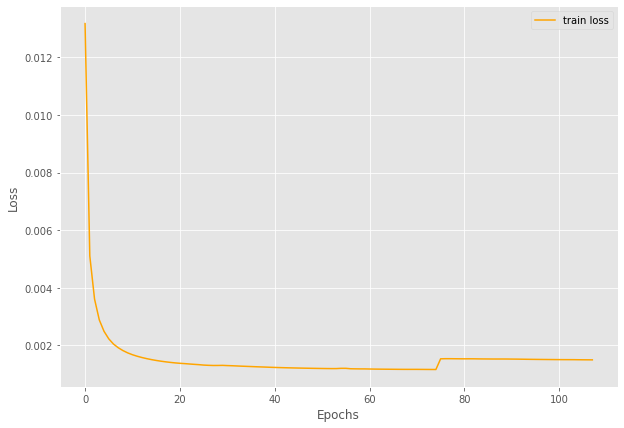

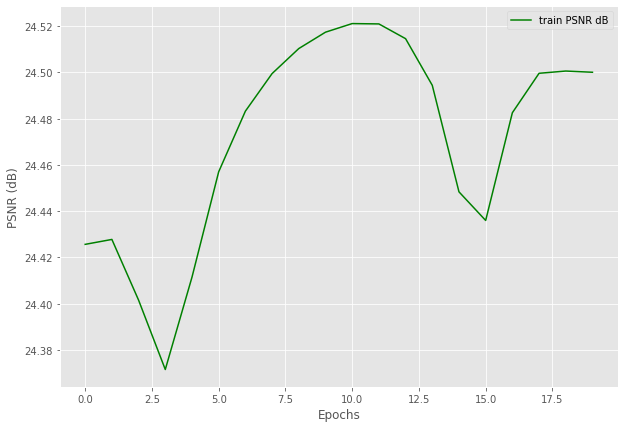

In [ ]:
# loss plots
curr_dir=os.getcwd()
output_dir="/content/drive/My Drive/Deep_Deblur_Data/outputs3"
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
#plt.plot(val_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
os.chdir(output_dir)  
plt.savefig('loss.jpg')
os.chdir(curr_dir)
plt.show()
# psnr plots
plt.figure(figsize=(10, 7))
plt.plot(train_psnr, color='green', label='train PSNR dB')

plt.xlabel('Epochs')
plt.ylabel('PSNR (dB)')
plt.legend()
os.chdir(output_dir)  
plt.savefig('psnr.jpg')
os.chdir(curr_dir)
plt.show()
# save the model to disk
# print('Saving model...')
# os.chdir(output_dir)  
# torch.save(model.state_dict(), 'model.pth')
# os.chdir(curr_dir)  



In [ ]:
# Take images in png format. For model(image), convert image to format- (N,H,W,C),i.e, (N,H,W,3). 
# For ssim, convert each image to form (1,C,H,W) or (1,3,H,W).
#Put 


test_dir="/content/drive/My Drive/GOPRO_Large_Data/GOPRO_Large/test"


dst="/content/drive/My Drive/DeepDeblur_Test"

res_d="/content/drive/My Drive/result"

psnr_list_glob=[]
ssim_list_glob=[]
dirr=[]



for dir in os.listdir(test_dir):
  test_blur=test_dir+"/"+dir+"/"+"blur_gamma"
  test_sharp=test_dir+"/"+dir+"/"+"sharp"

  dirr.append(dir)

  print("For ",test_blur,":- ")
  shutil.rmtree(dst)
  shutil.rmtree(res_d)
  os.mkdir(dst)
  os.mkdir(res_d)

  ss=0 
  cnt=0
  im=0
  for f in os.listdir(test_blur):
    path=test_blur+"/"+f 
    model.eval()
    with torch.no_grad():
      img=cv2.imread(path) 
      #print("f: ",f)

      print("SHARP- ")
      srp=cv2.imread(test_sharp+"/"+f)
      srp=cv2.resize(srp, (256,256), interpolation=cv2.INTER_CUBIC)
      cv2_imshow(srp)

      j2=cv2.resize(img, (256,256), interpolation=cv2.INTER_CUBIC)
      print("BLUR- ")
      cv2_imshow(j2)

      j2=torch.tensor(j2,dtype=float).to(device)
      j2=j2.reshape(1,j2.shape[0],j2.shape[1],j2.shape[2])
      #print("j2.shape- ",j2.shape)
      (a1,a2,a3) = model(j2)
      a3=a3.reshape(a3.shape[2],a3.shape[3],a3.shape[1])
      a3=a3.cpu().detach().numpy()

      os.chdir(res_d)
      cv2.imwrite(f,a3)

      print("Output:- ")
      cv2_imshow(a3)

      #print("H1")
      #time.sleep(15)  
      #print("H2")
      
      t1=cv2.imread(res_d+"/"+f)
      t2=cv2.imread(test_sharp+"/"+f)
      t2=cv2.resize(t2, (256,256), interpolation=cv2.INTER_CUBIC)


      t1=torch.tensor(t1,dtype=float)
      t2=torch.tensor(t2,dtype=float)

      p=psnr(t2,t1)
      t1=t1.reshape(1,t1.shape[2],t1.shape[0],t1.shape[1])
      t2=t2.reshape(1,t2.shape[2],t2.shape[0],t2.shape[1])
      q=calculate_ssim(t1,t2)
      #print("psnr- ",p)
      #print("ssim- ",q)
      print("")
      im+=q
      ss+=p
      cnt+=1


  print("Avg. PSNR is- ",ss/cnt)
  print("Avg. SSIM is- ",im/cnt)
  psnr_list_glob.append(ss/cnt)
  ssim_list_glob.append(im/cnt)
  print("-------------------------------------------------")

  # for f in os.listdir(test_sharp):
  #   os.remove(res_d+"/"+f)





For  /content/drive/My Drive/GOPRO_Large_Data/GOPRO_Large/test/Copy of airport_inside_0001.jpg :- 
BLUR- 


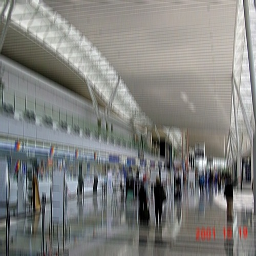

Output:- 


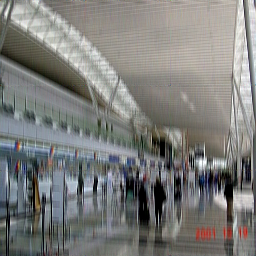

-------------------------------------------
For  /content/drive/My Drive/GOPRO_Large_Data/GOPRO_Large/test/Copy of airport_inside_0609.jpg :- 
BLUR- 


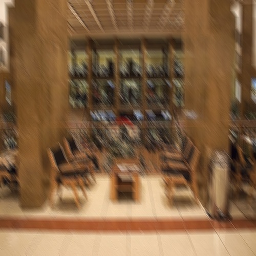

Output:- 


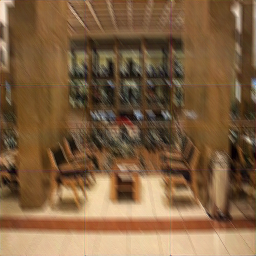

-------------------------------------------


In [ ]:
#Put blurred images in DeepDeblur_Test
#Output in result

test_sharp="/content/drive/My Drive/GOPRO_Large_Data/GOPRO_Large/test/GOPR0385_11_01/sharp"
dst="/content/drive/My Drive/DeepDeblur_Test"
res_d="/content/drive/My Drive/result"
psnr_list_glob=[]
ssim_list_glob=[]
dirr=[]

for f in os.listdir(dst):
  #test_blur=test_dir+"/"+f
  
  #dirr.append(dir)

  print("For ",test_blur,":- ")
  #shutil.rmtree(dst)
  shutil.rmtree(res_d)
  #os.mkdir(dst)
  os.mkdir(res_d)

  ss=0 
  cnt=0
  im=0
  
  model.eval()
  with torch.no_grad():
    path=dst+"/"+f
    img=cv2.imread(path) 
    #print("f: ",f)

    j2=cv2.resize(img, (256,256), interpolation=cv2.INTER_CUBIC)
    print("BLUR- ")
    cv2_imshow(j2)

    j2=torch.tensor(j2,dtype=float).to(device)
    j2=j2.reshape(1,j2.shape[0],j2.shape[1],j2.shape[2])
    #print("j2.shape- ",j2.shape)
    (a1,a2,a3) = model(j2)
    a3=a3.reshape(a3.shape[2],a3.shape[3],a3.shape[1])
    a3=a3.cpu().detach().numpy()

    os.chdir(res_d)
    cv2.imwrite(f,a3)

    print("Output:- ")
    cv2_imshow(a3)
    print("-------------------------------------------")
    #print("H1")
    #time.sleep(15)  
    #print("H2")
    
    t1=cv2.imread(res_d+"/"+f)
    t2=cv2.imread(test_sharp+"/"+f)
    t2=cv2.resize(t2, (256,256), interpolation=cv2.INTER_CUBIC)


    t1=torch.tensor(t1,dtype=float)
    t2=torch.tensor(t2,dtype=float)

    p=psnr(t2,t1)
    t1=t1.reshape(1,t1.shape[2],t1.shape[0],t1.shape[1])
    t2=t2.reshape(1,t2.shape[2],t2.shape[0],t2.shape[1])
    q=calculate_ssim(t1,t2)
    print("psnr- ",p)
    print("ssim- ",q)
    print("")
    im+=q
    ss+=p
    cnt+=1


  print("Avg. PSNR is- ",ss/cnt)
  print("Avg. SSIM is- ",im/cnt)
  psnr_list_glob.append(ss/cnt)
  ssim_list_glob.append(im/cnt)
  print("-------------------------------------------------")


In [ ]:
res1="/content/drive/My Drive/Deep_Deblur_Data/DeepDeblur-Pytorch/src"
if os.path.exists("/content/drive/My Drive/result"):
  shutil.rmtree("/content/drive/My Drive/result")

os.chdir("/content/drive/My Drive/")
os.mkdir("result")

if os.path.exists("/content/drive/My Drive/Deep_Deblur_Data/DeepDeblur-Pytorch/experiment/GOPRO_L1/result"):
  shutil.rmtree("/content/drive/My Drive/Deep_Deblur_Data/DeepDeblur-Pytorch/experiment/GOPRO_L1/result")

os.chdir("/content/drive/My Drive/Deep_Deblur_Data/DeepDeblur-Pytorch/experiment/GOPRO_L1")
os.mkdir("result")

os.chdir(res1)

!python main.py --save_dir "GOPRO_L1" --demo True --demo_input_dir "/content/drive/My Drive/DeepDeblur_Test" 
res_d="/content/drive/My Drive/Deep_Deblur_Data/DeepDeblur-Pytorch/experiment/GOPRO_L1/result"
for f in os.listdir(res_d):
  src=res_d+"/"+f
  dst="/content/drive/My Drive/result"
  shutil.copy(src, dst) 

===> Loading demo dataset: Demo
Loading model from ../experiment/GOPRO_L1/models/model-1000.pt
Loading optimizer from ../experiment/GOPRO_L1/optim/optim-1000.pt
Loss function: 1*L1
Metrics: PSNR,SSIM
Loading loss record from ../experiment/GOPRO_L1/loss.pt
===> Initializing trainer
results are saved in ../experiment/GOPRO_L1/result
|█████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.18s/it]


In [ ]:
# res1="/content/drive/My Drive/Deep_Deblur_Data/DeepDeblur-Pytorch/src"
# if os.path.exists("/content/drive/My Drive/result"):
#   shutil.rmtree("/content/drive/My Drive/result")

# os.chdir("/content/drive/My Drive/")
# os.mkdir("result")

# if os.path.exists("/content/drive/My Drive/Deep_Deblur_Data/DeepDeblur-Pytorch/experiment/GOPRO_L1/result"):
#   shutil.rmtree("/content/drive/My Drive/Deep_Deblur_Data/DeepDeblur-Pytorch/experiment/GOPRO_L1/result")

# os.chdir("/content/drive/My Drive/Deep_Deblur_Data/DeepDeblur-Pytorch/experiment/GOPRO_L1")
# os.mkdir("result")

# os.chdir(res1)

# !python main.py --save_dir "GOPRO_L1" --demo True --demo_input_dir "/content/drive/My Drive/DeepDeblur_Test" 
# res_d="/content/drive/My Drive/Deep_Deblur_Data/DeepDeblur-Pytorch/experiment/GOPRO_L1/result"
# for f in os.listdir(res_d):
#   src=res_d+"/"+f
#   dst="/content/drive/My Drive/result"
#   shutil.copy(src, dst) 

main="/content/drive/My Drive/set5_data/blurred_set5_images_0"
os.chdir("/content/drive/My Drive/result")
!ls

k=0
for f in os.listdir(main):
  t1=cv2.imread(main+"/"+f)
  print("f: ",f)
  #print("t1: ",t1)
  
  t2=cv2.imread("/content/drive/My Drive/result/"+f[:-3]+"png")
  t1=torch.tensor(t1,dtype=float).to(device)
  t2=torch.tensor(t2,dtype=float).to(device)
  #print("t2: ",t2)
  p=psnr(t1,t2)
  k+=p
  print("p: ",p)
print("Avg:- ",k/5)  

blurred_img_001_0.png  blurred_img_004_0.png  to_test_2.png
blurred_img_002_0.png  blurred_img_005_0.png  to_test_3.png
blurred_img_003_0.png  to_test_1.png
f:  blurred_img_005_0.jpg
p:  tensor(37.6417, device='cuda:0', dtype=torch.float64)
f:  blurred_img_004_0.jpg
p:  tensor(24.6302, device='cuda:0', dtype=torch.float64)
f:  blurred_img_001_0.jpg
p:  tensor(36.1728, device='cuda:0', dtype=torch.float64)
f:  blurred_img_003_0.jpg
p:  tensor(34.0425, device='cuda:0', dtype=torch.float64)
f:  blurred_img_002_0.jpg
p:  tensor(29.9729, device='cuda:0', dtype=torch.float64)
Avg:-  tensor(32.4920, device='cuda:0', dtype=torch.float64)


In [ ]:
ll=[32.3841,31.9673,31.9717, 32.3701,29.8410,28.1531,27.7464, 28.5423,29.6392,28.7411, 32.5808]
print(sum(ll)/len(ll))
ll2=[0.9296210264863458, 0.9387421355595822, 0.9273857343886331, 0.9530981343384463, 0.8930841420410678, 0.8484772558723551, 0.8563570627543269, 0.8788718981356146, 0.8710433634518363, 0.8689062388926581, 0.9462195885847976]
print(sum(ll2)/len(ll2))
x=[23.0712,20.7203,25.1110,21.0744,19.4772,23.5395,22.0548,18.0240,18.7701,20.0098]
print(sum(x)/len(x))

30.357918181818185
0.901073325500515
21.185229999999997
